#TAAC - Assignment 2

Faculty of Engineering, University of Porto Master in Data Science and Enginnering

Karim Kousa up202102687 | Silvia Tavares up202204392 | Francisco Cuervo up202302145 | Sónia Ferreira up202200967

MECD, November 2023

## **1. Convolutional Neural Networks (50%)**

###(a)
(15%) Describe, in your own words, the expected behaviour in a convolutional layer, in terms of output and input dimensions, if we:

i. (5%) Change the padding from 0 to 1.

ii. (5%) Change the kernel size from 3 to 4.

iii. (5%) Change the stride from 1 to 2

The output size of the convolution layer is defined by the formula:


<center>$n_{out}$ = $\frac{n_{in} + 2p - k}{s} + 1$ $\quad$ (1)</center>

Where:
- $n_{out}$ : number of output features.
- $n_{in}$ : number of input features.
- p : padding size.
- k : kernel size.
- s : stride size.

a) By changing the padding from 0 to 1, we add a border of zeros around the input. This maintains the size of the result ($n_{out}$) instead of shrinking.

b) Changing the kernel or filter size from 3 to 4 results in a 4x4 filter, leading to a larger numerator in equation (1) and consequently a bigger ($n_{out}$).

c) Changing the stride from 1 to 2 results in a smaller output size ($n_{out}$) as the denominator in equation (1) increases.


### (b)
(15%) Frequently, after a convolutional layer and respective activation, it is possible to find a pooling
layer. Describe this layer and comment the following statement: ”Pooling layers introduce a trade-off
between information loss and dimensionality reduction”.

Pooling layers in CNNs reduce the input volume's spatial dimensions (width and height) from previous convolutional layers while keeping important information. This decrease helps regulate overfitting and computational efficiency by controlling network parameters and calculations.
It reduces intermediate feature sizes and number of layers necessary. It is used in all convolutional tasks, including image and text classification.

Max Pooling and Average Pooling are the most common pooling layers:

  &emsp;&emsp;Max Pooling: This pooling approach keeps the highest value from each input feature map region. This helps retain each zone's most activated features.

   &emsp;&emsp;Average Pooling: The average value of each region in the input feature map is calculated and stored in average pooling. This capture of the most highly activated features within each region.

Pooling layers balance information loss and dimensionality for the following reasons:

  &emsp;&emsp;Information Loss: When reducing or subsampling input, pooling, especially with larger pool sizes or strides, eliminates certain information. The model's ability to locate features may be degraded without spatial information.

  &emsp;&emsp;Dimensionality Reduction: Reducing spatial dimensionality reduces computing load and model overfitting. However, significantly lowering spatial dimensions could remove crucial information for accurate forecasts.

Thus, kernel size and pooling layer stride are crucial design decisions. Pool operations with smaller filter size and strides retain more spatial information while limiting dimensionality loss. However, increasing the pool size and stride length decreases dimensionality more efficiently, but small input details may be missed.

Pooling layers reduce dimensionality, but they may also exclude key input information, reducing the model's ability to effectively represent specific features. CNN performance depends on balancing dimensionality reduction and information retention.

### (c)

i. (10%) Build a custom CNN composed of 5 convolutional layers with ReLU activation between all the five layers and a fully-connected output layer. From the second to the third convolutional layer add a pooling layer. Train this CNN on PyTorch’s Fashion-MNIST dataset (PyTorch Class), using Adam, a learning rate of 0.01 and Cross-Entropy. Feel free to define the hyperparameters of your convolutional and pooling layers. Train as many epochs as you find necessary. Report your accuracy, loss and number of epochs to convergence (if the network converges).

In [1]:
from google.colab import drive
from google.colab import files
import os
import numpy as np
import cv2
import glob
from google.colab.patches import cv2_imshow
import pandas as pd
from matplotlib import pyplot as plt
import copy
import json
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, random_split
from torch.optim import Adam, SGD, NAdam
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from PIL import Image
from tqdm import tqdm
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from torch.utils.data.sampler import SubsetRandomSampler
import seaborn as sns
from torchvision import models, datasets
from torchsummary import summary
import torch.optim as optim
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer


In [2]:
# get cpu or gpu device for training
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [3]:
data_aug = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,))]) # the ToTensor transform scales the image into [0., 1.0] range

training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=data_aug,
)
validation_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=data_aug,
)

# Split the validation set into validation and test sets
validation_size = len(validation_data)
test_size = int(0.2 * validation_size)

# Use random_split for a proper split
validation_data, test_data = random_split(validation_data, [validation_size - test_size, test_size])


100%|██████████| 9912422/9912422 [00:00<00:00, 158635665.97it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 110930122.55it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 29959415.52it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 24392482.42it/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [4]:
print(f"Training size: {len(training_data)}\nValidation size: {len(validation_data)}\nTest size: {len(test_data)}")

Training size: 60000
Validation size: 8000
Test size: 2000


In [5]:
# Check class distribution
class_counts = torch.bincount(training_data.targets)
class_labels = [str(i) for i in range(len(class_counts))]

# Print class distribution
for label, count in zip(class_labels, class_counts):
    print(f"Class {label}: {count} samples")

Class 0: 5923 samples
Class 1: 6742 samples
Class 2: 5958 samples
Class 3: 6131 samples
Class 4: 5842 samples
Class 5: 5421 samples
Class 6: 5918 samples
Class 7: 6265 samples
Class 8: 5851 samples
Class 9: 5949 samples


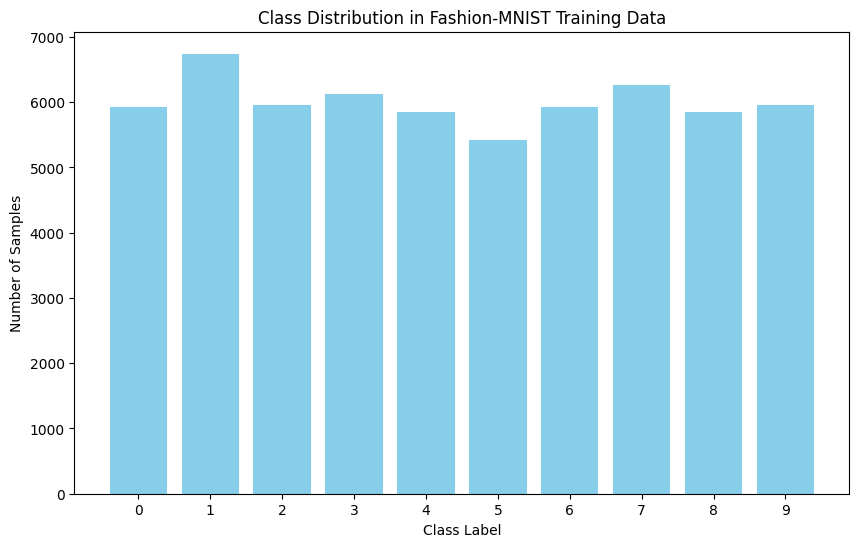

In [6]:
# Class distribution data
class_counts = class_counts.cpu().numpy()  # Convert to NumPy array for plotting

# Create a bar chart
plt.figure(figsize=(10, 6))
plt.bar(class_labels, class_counts, color='skyblue')
plt.xlabel('Class Label')
plt.ylabel('Number of Samples')
plt.title('Class Distribution in Fashion-MNIST Training Data')
plt.show()

In [7]:
batch_size = 64
num_workers = 2 # how many processes are used to load the data

trainloader = DataLoader(training_data, batch_size=batch_size, shuffle=True, num_workers=num_workers)
validationloader = DataLoader(validation_data, batch_size=batch_size, shuffle=False, num_workers=num_workers)
testloader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=num_workers)

In [8]:
print(f"Training size: {len(trainloader)}\nValidation size: {len(validationloader)}\nTest size: {len(testloader)}")

Training size: 938
Validation size: 125
Test size: 32


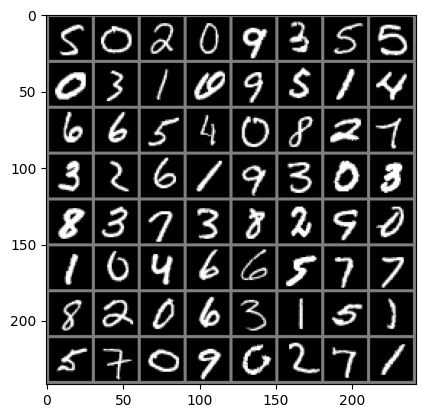

In [9]:
#Show some of the training images.
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5     # unnormalize'
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))

In [10]:
images[3].size()

torch.Size([1, 28, 28])

In [11]:
labels[4]

tensor(9)

In [12]:
# Hyperparameters
learning_rate = 0.01
epochs = 30

Besides what was asked we also added dropout to help prevent overfitting.

In [13]:
class ConvolutionalNeuralNetwork(nn.Module):
    def __init__(self):
        super(ConvolutionalNeuralNetwork, self).__init__()
        self.pool_size = 2
        self.nb_filters = 32
        self.kernel_size = 3

        self.layers = nn.Sequential(
            nn.Conv2d(1, self.nb_filters, self.kernel_size),
            nn.ReLU(),
            nn.Conv2d(self.nb_filters, self.nb_filters, self.kernel_size),
            nn.ReLU(),
            nn.MaxPool2d(self.pool_size),
            nn.Conv2d(self.nb_filters, self.nb_filters, self.kernel_size),
            nn.ReLU(),
            nn.Conv2d(self.nb_filters, self.nb_filters, self.kernel_size),
            nn.ReLU(),
            nn.Conv2d(self.nb_filters, self.nb_filters, self.kernel_size),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(1152, 128),
            nn.ReLU(),
            nn.Linear(128, 10),
        )

    def forward(self, x):
        logits = self.layers(x)
        return logits

model = ConvolutionalNeuralNetwork().to(device) # put model in device (GPU or CPU)
print(model)

ConvolutionalNeuralNetwork(
  (layers): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (6): ReLU()
    (7): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (8): ReLU()
    (9): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (10): ReLU()
    (11): Flatten(start_dim=1, end_dim=-1)
    (12): Linear(in_features=1152, out_features=128, bias=True)
    (13): ReLU()
    (14): Linear(in_features=128, out_features=10, bias=True)
  )
)


In [14]:
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 26, 26]             320
              ReLU-2           [-1, 32, 26, 26]               0
            Conv2d-3           [-1, 32, 24, 24]           9,248
              ReLU-4           [-1, 32, 24, 24]               0
         MaxPool2d-5           [-1, 32, 12, 12]               0
            Conv2d-6           [-1, 32, 10, 10]           9,248
              ReLU-7           [-1, 32, 10, 10]               0
            Conv2d-8             [-1, 32, 8, 8]           9,248
              ReLU-9             [-1, 32, 8, 8]               0
           Conv2d-10             [-1, 32, 6, 6]           9,248
             ReLU-11             [-1, 32, 6, 6]               0
          Flatten-12                 [-1, 1152]               0
           Linear-13                  [-1, 128]         147,584
             ReLU-14                  [

In [15]:
# Initialize the model, loss function, and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [16]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import f1_score

def epoch_iter(dataloader, model, loss_fn, optimizer=None, is_train=True):
    total_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    if is_train:
        model.train()
    else:
        model.eval()

    all_predictions = []
    all_targets = []

    for inputs, targets in dataloader:
        inputs, targets = inputs.to(device), targets.to(device)

        if is_train:
            optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = loss_fn(outputs, targets)

        if is_train:
            # Backward pass and optimization
            loss.backward()
            optimizer.step()

        # Update loss and accuracy
        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == targets).sum().item()
        total_samples += targets.size(0)

        # Collect predictions and targets for F1 score calculation
        all_predictions.extend(predicted.cpu().numpy())
        all_targets.extend(targets.cpu().numpy())

    # Calculate accuracy and F1 score
    accuracy = correct_predictions / total_samples
    f1 = f1_score(all_targets, all_predictions, average='macro')

    # Calculate average loss
    avg_loss = total_loss / len(dataloader)

    return avg_loss, accuracy, f1


In [17]:
def train_and_validate(model, model_name, train_dataloader, validation_dataloader, loss_fn, optimizer, num_epochs ):
    train_history = {'loss': [], 'accuracy': [], 'f1_score': []}
    val_history = {'loss': [], 'accuracy': [], 'f1_score': []}
    best_val_loss = np.inf
    best_val_acc = 0.0
    best_val_f1 = 0.0
    best_epoch = 0

    print("Start training...")
    for t in range(num_epochs):
        print(f"\nEpoch {t+1}")
        train_loss, train_acc, train_f1 = epoch_iter(train_dataloader, model, loss_fn, optimizer)
        print(f"Train loss: {train_loss:.3f} \t Train acc: {train_acc:.3f} \t Train F1: {train_f1:.3f}")

        val_loss, val_acc, val_f1 = epoch_iter(validation_dataloader, model, loss_fn, is_train=False)
        print(f"Val loss: {val_loss:.3f} \t Val acc: {val_acc:.3f} \t Val F1: {val_f1:.3f}")

        # Save model when val loss or accuracy improves
        if val_loss < best_val_loss or val_acc > best_val_acc:
            best_val_loss = val_loss
            best_val_acc = val_acc
            best_val_f1 = val_f1
            best_epoch = t

            save_dict = {'model': model.state_dict(), 'optimizer': optimizer.state_dict(), 'epoch': t}
            torch.save(save_dict, model_name + '_best_model.pth')

        # Save latest model
        save_dict = {'model': model.state_dict(), 'optimizer': optimizer.state_dict(), 'epoch': t}
        torch.save(save_dict, model_name + '_latest_model.pth')

        # Save training history for plotting purposes
        train_history["loss"].append(train_loss)
        train_history["accuracy"].append(train_acc)
        train_history["f1_score"].append(train_f1)

        val_history["loss"].append(val_loss)
        val_history["accuracy"].append(val_acc)
        val_history["f1_score"].append(val_f1)

    print("Finished")
    return train_history, val_history, best_val_acc, best_val_loss, best_val_f1, best_epoch


In [18]:
# Call the train_and_validate function
model_name = 'cnn'
train_history, val_history, best_val_acc, best_val_loss, best_val_f1, best_epoch = train_and_validate(model,model_name, trainloader, validationloader, loss_fn, optimizer, num_epochs=epochs )

print(f"Best validation accuracy: {best_val_acc:.3f}")
print(f"Best validation loss: {best_val_loss:.3f}")
print(f"Best validation F1-score: {best_val_f1:.3f}")
print(f"F1-score at the best epoch ({best_epoch + 1}): {val_history['f1_score'][best_epoch]:.3f}")

Start training...

Epoch 1
Train loss: 0.205 	 Train acc: 0.935 	 Train F1: 0.935
Val loss: 0.113 	 Val acc: 0.966 	 Val F1: 0.965

Epoch 2
Train loss: 0.098 	 Train acc: 0.972 	 Train F1: 0.972
Val loss: 0.104 	 Val acc: 0.967 	 Val F1: 0.967

Epoch 3
Train loss: 0.107 	 Train acc: 0.970 	 Train F1: 0.969
Val loss: 0.095 	 Val acc: 0.971 	 Val F1: 0.970

Epoch 4
Train loss: 0.090 	 Train acc: 0.974 	 Train F1: 0.974
Val loss: 0.128 	 Val acc: 0.967 	 Val F1: 0.966

Epoch 5
Train loss: 0.097 	 Train acc: 0.972 	 Train F1: 0.972
Val loss: 0.090 	 Val acc: 0.975 	 Val F1: 0.975

Epoch 6
Train loss: 0.085 	 Train acc: 0.976 	 Train F1: 0.975
Val loss: 0.119 	 Val acc: 0.969 	 Val F1: 0.969

Epoch 7
Train loss: 0.078 	 Train acc: 0.977 	 Train F1: 0.977
Val loss: 0.102 	 Val acc: 0.974 	 Val F1: 0.973

Epoch 8
Train loss: 0.095 	 Train acc: 0.974 	 Train F1: 0.973
Val loss: 0.102 	 Val acc: 0.973 	 Val F1: 0.972

Epoch 9
Train loss: 0.100 	 Train acc: 0.973 	 Train F1: 0.973
Val loss: 0.10

In [19]:
def plotTrainingHistory(train_history, val_history):
    plt.subplot(2, 1, 1)
    plt.title('Cross Entropy Loss')
    plt.plot(train_history['loss'], label='train')
    plt.plot(val_history['loss'], label='val')
    plt.legend(loc='best')

    plt.subplot(2, 1, 2)
    plt.title('Classification Accuracy')
    plt.plot(train_history['accuracy'], label='train')
    plt.plot(val_history['accuracy'], label='val')

    plt.tight_layout()
    plt.legend(loc='best')
    plt.show()

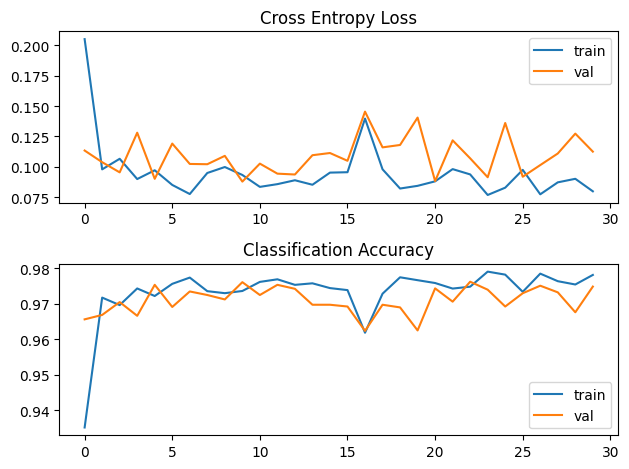

In [20]:
plotTrainingHistory(train_history, val_history)

**Testing the Model**

In [21]:
# Load the model
model = ConvolutionalNeuralNetwork().to(device)
checkpoint = torch.load('cnn_best_model.pth')
model.load_state_dict(checkpoint['model'])

<All keys matched successfully>

In [22]:
from sklearn.metrics import f1_score, confusion_matrix

def test_model(model, testloader, loss_fn):
    test_loss = 0.0
    correct_predictions = 0
    total_samples = 0
    all_preds = []
    all_labels = []

    model.eval()  # Set the model to evaluation mode

    with torch.no_grad():  # Disable gradient computation during testing
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = loss_fn(outputs, labels)

            test_loss += loss.item()

            _, preds = torch.max(outputs, 1)
            correct_predictions += (preds == labels).sum().item()
            total_samples += labels.size(0)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = correct_predictions / total_samples

    # Confusion Matrix
    conf_matrix = confusion_matrix(all_labels, all_preds)

    # F1-score
    f1 = f1_score(all_labels, all_preds, average='weighted')

    return test_loss / len(testloader), accuracy, f1, conf_matrix

# Test the model
test_loss, test_accuracy, test_f1, test_conf_matrix = test_model(model, testloader, loss_fn)

print(f"Test Loss: {test_loss:.3f}")
print(f"Test Accuracy: {test_accuracy:.3f}")
print(f"Test F1-score: {test_f1:.3f}")

Test Loss: 0.104
Test Accuracy: 0.980
Test F1-score: 0.980


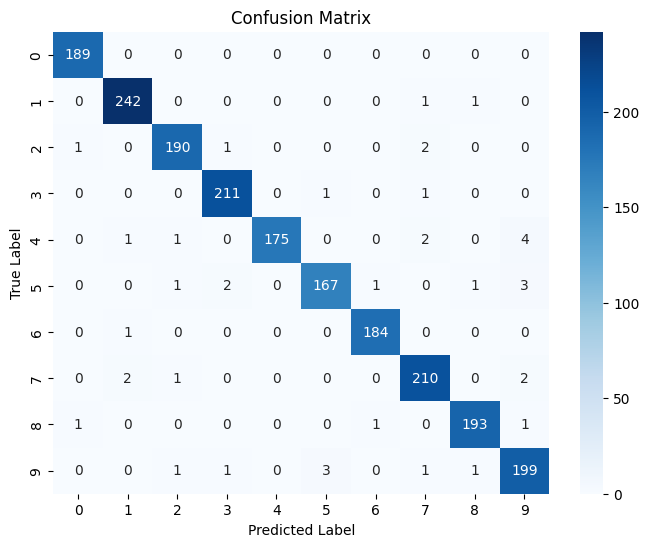

In [23]:
# Plotting the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(test_conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=range(10), yticklabels=range(10))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

ii. (5%) Redo the previous exercise but use a ResNet-18 without pre-trained weights. Train as many
epochs as you find necessary. Report your accuracy, loss and number of epochs to convergence
(if the network converges)


In [ ]:
from torchvision.models import resnet18

batch_size = 64
num_workers = 2 # how many processes are used to load the data

# Load Fashion-MNIST dataset
transform = transforms.Compose([transforms.Grayscale(num_output_channels=3),  # Convert to 3 channels for ResNet
                                transforms.Resize((224, 224)),  # Resize to match ResNet input size
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])
train_dataset = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=transform,
)
validation_dataset = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=transform,
)

# Split the validation set into validation and test sets
validation_size = len(validation_dataset)
test_size = int(0.2 * validation_size)

# Use random_split for a proper split
validation_data, test_dataset = random_split(validation_dataset, [validation_size - test_size, test_size])

trainloader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
validationloader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
testloader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

In [ ]:
print(f"Training size: {len(train_dataset)}\nValidation size: {len(validation_dataset)}\nTest size: {len(test_dataset)}")

Training size: 60000
Validation size: 10000
Test size: 2000


In [ ]:
# Hyperparameters
learning_rate = 0.01
epochs = 5

In [ ]:
# Initialize the ResNet-18 model
model = resnet18(num_classes=10, pretrained=False)

# Modify the first layer to accept grayscale images
model.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)

# Print the modified ResNet-18 architecture
print(model)

# Initialize the loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [ ]:
model = model.to(device)
model_name = 'resnet18'
# Call the train_and_validate function
train_history, val_history, best_val_acc, best_val_loss, best_val_f1, best_epoch = train_and_validate(model,model_name, trainloader, validationloader, loss_fn, optimizer, num_epochs=epochs )

print(f"Best validation accuracy: {best_val_acc:.3f}")
print(f"Best validation loss: {best_val_loss:.3f}")
print(f"Best validation F1-score: {best_val_f1:.3f}")
print(f"F1-score at the best epoch ({best_epoch + 1}): {val_history['f1_score'][best_epoch]:.3f}")

Start training...

Epoch 1
Train loss: 0.196 	 Train acc: 0.939 	 Train F1: 0.939
Val loss: 0.260 	 Val acc: 0.914 	 Val F1: 0.914

Epoch 2
Train loss: 0.052 	 Train acc: 0.984 	 Train F1: 0.984
Val loss: 0.077 	 Val acc: 0.975 	 Val F1: 0.975

Epoch 3
Train loss: 0.040 	 Train acc: 0.987 	 Train F1: 0.987
Val loss: 0.037 	 Val acc: 0.988 	 Val F1: 0.988

Epoch 4
Train loss: 0.036 	 Train acc: 0.989 	 Train F1: 0.989
Val loss: 0.034 	 Val acc: 0.990 	 Val F1: 0.990

Epoch 5
Train loss: 0.028 	 Train acc: 0.991 	 Train F1: 0.991
Val loss: 0.027 	 Val acc: 0.991 	 Val F1: 0.991
Finished
Best validation accuracy: 0.991
Best validation loss: 0.027
Best validation F1-score: 0.991
F1-score at the best epoch (5): 0.991


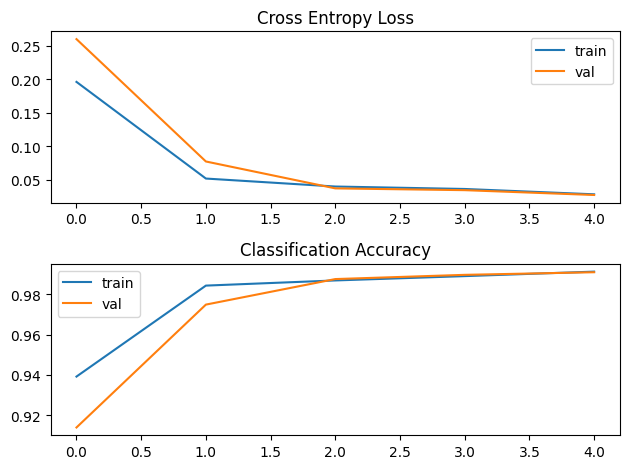

In [ ]:
plotTrainingHistory(train_history, val_history)

**Testing The Model**

In [ ]:
# Load the model
model = model.to(device)
checkpoint = torch.load('resnet18_best_model.pth')
model.load_state_dict(checkpoint['model'])

<All keys matched successfully>

In [ ]:
# Set model to evaluation mode
model.eval()

# Variables to store accuracy, loss, and predictions
total_correct = 0
total_samples = 0
total_loss = 0
all_predictions = []
all_targets = []

# Iterate over batches in the test loader
with torch.no_grad():
    for inputs, targets in testloader:
        inputs, targets = inputs.to(device), targets.to(device)

        # Forward pass
        outputs = model(inputs)
        loss = loss_fn(outputs, targets)

        # Update accuracy, loss, and predictions
        _, predicted = torch.max(outputs, 1)
        total_correct += (predicted == targets).sum().item()
        total_samples += targets.size(0)
        total_loss += loss.item()

        # Collect predictions and targets for F1 score calculation
        all_predictions.extend(predicted.cpu().numpy())
        all_targets.extend(targets.cpu().numpy())

# Calculate accuracy, loss, and F1 score
accuracy = total_correct / total_samples
average_loss = total_loss / len(testloader)
f1 = f1_score(all_targets, all_predictions, average='macro')

print(f"Test Accuracy: {accuracy * 100:.2f}%")
print(f"Test Loss: {average_loss:.4f}")
print(f"F1 Score: {f1:.4f}")

Test Accuracy: 99.00%
Test Loss: 0.0313
F1 Score: 0.9899


In [ ]:
summary(model, (3, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 14, 14]           9,408
       BatchNorm2d-2           [-1, 64, 14, 14]             128
              ReLU-3           [-1, 64, 14, 14]               0
         MaxPool2d-4             [-1, 64, 7, 7]               0
            Conv2d-5             [-1, 64, 7, 7]          36,864
       BatchNorm2d-6             [-1, 64, 7, 7]             128
              ReLU-7             [-1, 64, 7, 7]               0
            Conv2d-8             [-1, 64, 7, 7]          36,864
       BatchNorm2d-9             [-1, 64, 7, 7]             128
             ReLU-10             [-1, 64, 7, 7]               0
       BasicBlock-11             [-1, 64, 7, 7]               0
           Conv2d-12             [-1, 64, 7, 7]          36,864
      BatchNorm2d-13             [-1, 64, 7, 7]             128
             ReLU-14             [-1, 6


iii. (5%) Repeat the previous exercise, but using a pre-trained ResNet-18. Train as many epochs
as you find necessary. Report your accuracy, loss and number of epochs to convergence (if the
network converges)

In [ ]:
# Load pre-trained ResNet-18 model
model = resnet18(pretrained=True)

# Modify the final fully connected layer to have 10 output classes (Fashion-MNIST classes)
model.fc = nn.Linear(model.fc.in_features, 10)

# Print the modified ResNet-18 architecture
print(model)

# Freeze the pre-trained layers (optional)
for param in model.parameters():
    param.requires_grad = False

# Unfreeze the final fully connected layer for fine-tuning
for param in model.fc.parameters():
    param.requires_grad = True

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 103MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
# Hyperparameters
learning_rate = 0.01 #0.001
epochs = 5

In [ ]:
# Initialize the loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
model = model.to(device)
model_name = 'resnet18_p'
# Call the train_and_validate function
train_history, val_history, best_val_acc, best_val_loss, best_val_f1, best_epoch = train_and_validate(model,model_name, trainloader, validationloader, loss_fn, optimizer, num_epochs=epochs )

print(f"Best validation accuracy: {best_val_acc:.3f}")
print(f"Best validation loss: {best_val_loss:.3f}")
print(f"Best validation F1-score: {best_val_f1:.3f}")
print(f"F1-score at the best epoch ({best_epoch + 1}): {val_history['f1_score'][best_epoch]:.3f}")

Start training...

Epoch 1
Train loss: 0.270 	 Train acc: 0.919 	 Train F1: 0.918
Val loss: 0.137 	 Val acc: 0.956 	 Val F1: 0.956

Epoch 2
Train loss: 0.192 	 Train acc: 0.945 	 Train F1: 0.944
Val loss: 0.213 	 Val acc: 0.941 	 Val F1: 0.942

Epoch 3
Train loss: 0.191 	 Train acc: 0.950 	 Train F1: 0.949
Val loss: 0.139 	 Val acc: 0.966 	 Val F1: 0.965

Epoch 4
Train loss: 0.205 	 Train acc: 0.950 	 Train F1: 0.950
Val loss: 0.295 	 Val acc: 0.936 	 Val F1: 0.937

Epoch 5
Train loss: 0.196 	 Train acc: 0.955 	 Train F1: 0.954
Val loss: 0.194 	 Val acc: 0.955 	 Val F1: 0.954
Finished
Best validation accuracy: 0.966
Best validation loss: 0.139
Best validation F1-score: 0.965
F1-score at the best epoch (3): 0.965


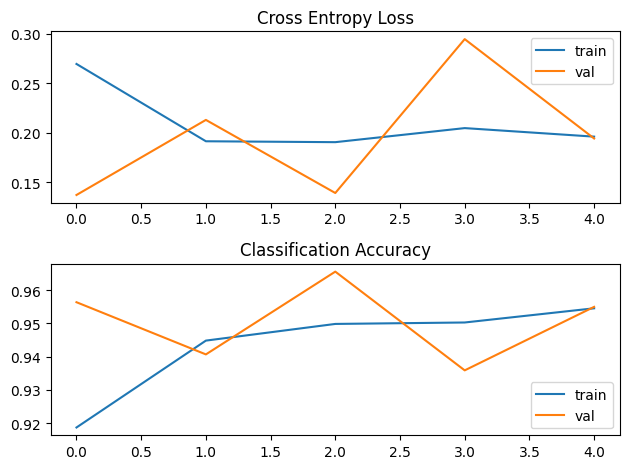

In [ ]:
plotTrainingHistory(train_history, val_history)

**Testing the Model**

In [ ]:
# Load the model
model = model.to(device)
checkpoint = torch.load('resnet18_p_best_model.pth')
model.load_state_dict(checkpoint['model'])

<All keys matched successfully>

In [ ]:
# Set model to evaluation mode
model.eval()

# Variables to store accuracy, loss, and predictions
total_correct = 0
total_samples = 0
total_loss = 0
all_predictions = []
all_targets = []

# Iterate over batches in the test loader
with torch.no_grad():
    for inputs, targets in testloader:
        inputs, targets = inputs.to(device), targets.to(device)

        # Forward pass
        outputs = model(inputs)
        loss = loss_fn(outputs, targets)

        # Update accuracy, loss, and predictions
        _, predicted = torch.max(outputs, 1)
        total_correct += (predicted == targets).sum().item()
        total_samples += targets.size(0)
        total_loss += loss.item()

        # Collect predictions and targets for F1 score calculation
        all_predictions.extend(predicted.cpu().numpy())
        all_targets.extend(targets.cpu().numpy())

# Calculate accuracy, loss, and F1 score
accuracy = total_correct / total_samples
average_loss = total_loss / len(testloader)
f1 = f1_score(all_targets, all_predictions, average='macro')

print(f"Test Accuracy: {accuracy * 100:.2f}%")
print(f"Test Loss: {average_loss:.4f}")
print(f"F1 Score: {f1:.4f}")

Test Accuracy: 95.95%
Test Loss: 0.1660
F1 Score: 0.9590


In [ ]:
summary(model, (3, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 14, 14]           9,408
       BatchNorm2d-2           [-1, 64, 14, 14]             128
              ReLU-3           [-1, 64, 14, 14]               0
         MaxPool2d-4             [-1, 64, 7, 7]               0
            Conv2d-5             [-1, 64, 7, 7]          36,864
       BatchNorm2d-6             [-1, 64, 7, 7]             128
              ReLU-7             [-1, 64, 7, 7]               0
            Conv2d-8             [-1, 64, 7, 7]          36,864
       BatchNorm2d-9             [-1, 64, 7, 7]             128
             ReLU-10             [-1, 64, 7, 7]               0
       BasicBlock-11             [-1, 64, 7, 7]               0
           Conv2d-12             [-1, 64, 7, 7]          36,864
      BatchNorm2d-13             [-1, 64, 7, 7]             128
             ReLU-14             [-1, 6

## **2. Natural language processing (50%)**



### (a)
(15%) You are in the process of training a machine learning model and you anticipate the occurrence of numerous out-of-vocabulary words during test time. Given this consideration, what type of tokenization would you opt for and why?

When we are dealing with the anticipation of numerous out-of-vocabulary words during test time, it's essential to choose a tokenization strategy that can effectively handle such scenarios. One common approach is to use subword tokenization or byte pair encoding (BPE). The main reasons are:

1. **Flexibility:**
   - **Subword Tokenization:** Subword tokenization, such as BPE, breaks words into smaller subword units. This enables the model to represent a larger vocabulary, including rare or out-of-vocabulary words, by combining subword units that it has encountered during training. This flexibility is especially useful when dealing with diverse and dynamic vocabularies.

2. **Handling Out-of-Vocabulary Words:**
   - **Subword Tokenization:** Since subword tokenization breaks words into smaller units, it can handle out-of-vocabulary words by representing them as combinations of known subwords. This allows the model to generalize well to previously unseen words during test time.

3. **Data Efficiency:**
   - **Subword Tokenization:** BPE and similar methods are data-efficient, as they adapt to the data during training and can represent rare words or morphological variations effectively. This can be particularly beneficial when working with limited training data.

4. **Language Agnosticism:**
   - **Subword Tokenization:** Subword methods are relatively language-agnostic. They can adapt to different languages and handle variations in word morphology. This makes them suitable for tasks that involve multiple languages or domains with diverse vocabularies.

5. **Reduced Vocabulary Size:**
   - **Subword Tokenization:** By breaking words into subword units, the overall vocabulary size is reduced, which can be advantageous for memory and computational efficiency.

Byte pair encoding, in particular, has gained popularity in natural language processing tasks for its ability to handle a wide range of vocabulary sizes effectively. It involves iteratively merging the most frequent pairs of consecutive bytes (subword units) until a desired vocabulary size is reached.

We believe that experimentation and evaluation on a validation set can help determine the most suitable tokenization approach for the machine learning model.

###(b)
(10%) The following vocabulary has been constructed from a collection of 100 documents denoted as C:


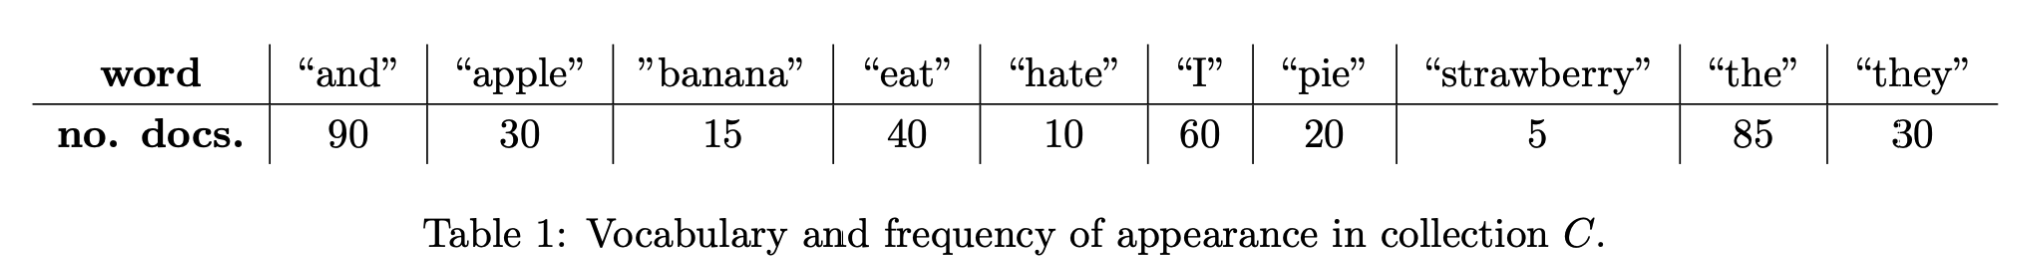

Considering the sentence “You and I eat the strawberry pie”:

i. (5%) Compute its bag-of-words representation.

ii. (5%) Compute its TF-IDF representation.

Before starting, there is variations between the formulas provided on the sheets and those implemented using TfidfVectorizer in scikit-learn include:

1. **IDF Calculation:**
   - Provided Formula:
   IDF (w, C) = log( Number of documents in C / Number of documents in C where w appears )
   - TfidfVectorizer: Uses a slight variation to avoid division by zero.
   
   It calculates IDF as: log((1 + Number of documents in C) / (1 + Number of documents in C where w appears)) + 1

2. **Normalization:**
   - Provided Formula: TF-IDF is computed as TF-IDF (w, T, C) = tf (w, T) * idf (w, C)
   - TfidfVectorizer: Normalizes the TF-IDF values to have unit Euclidean norm for each document.

3. **Term Frequency (TF) Calculation:**
   - Provided Formula: tf (w, T) = Number of occurrences of w in T / Number of words in T
   - TfidfVectorizer: Uses a slightly different normalization, dividing by the total number of terms in the document.

Despite these variations, the scikit-learn implementation is designed to provide efficient and consistent results for TF-IDF representations in real-world scenarios. The differences arise from considerations such as numerical stability and handling edge cases to ensure robustness in practical applications.


In [ ]:
# Given vocabulary and frequency of appearance
data = {
    'word': ["and", "apple", "banana", "eat", "hate", "I", "pie", "strawberry", "the", "they"],
    'no_docs': [90, 30, 15, 40, 10, 60, 20, 5, 85, 30]
}

# Convert the vocabulary to lowercase
data['word'] = [word.lower() for word in data['word']]

# Create a DataFrame from the given data
df = pd.DataFrame(data)

# Print the original data
print("Original Data:")
print(df.to_markdown(index=False))
print()

# Sentence to analyze
sentence = "You and I eat the strawberry pie"

# i. Compute bag-of-words representation
count_vectorizer = CountVectorizer(vocabulary=df['word'].tolist(), lowercase=False)
bow_representation = count_vectorizer.transform([sentence])

# Convert the bag-of-words representation to a DataFrame
bow_df = pd.DataFrame(bow_representation.toarray(), columns=df['word'])

# Display the results
print("\nTerm Frequency (TF) Calculation for the Sentence:\n", sentence)
print(bow_df.to_markdown(index=False))

# ii. Compute TF-IDF representation
tfidf_vectorizer = TfidfVectorizer(vocabulary=df['word'].tolist(), lowercase=False)
tfidf_representation = tfidf_vectorizer.fit_transform([sentence])

# Inverse Document Frequency (IDF) Calculation
idf_values = tfidf_vectorizer.idf_
df_idf = pd.DataFrame(list(zip(df['word'], idf_values)), columns=['word', 'IDF'])

print("\nInverse Document Frequency (IDF) Calculation:\n")
print(df_idf.to_markdown(index=False))

# TF-IDF Calculation
tfidf_df = pd.DataFrame(tfidf_representation.toarray(), columns=df['word'])
tfidf_result_df = tfidf_df * df_idf['IDF'].values
print("\nTF-IDF Calculation:\n")
print(tfidf_result_df.to_markdown(index=False))


Original Data:
| word       |   no_docs |
|:-----------|----------:|
| and        |        90 |
| apple      |        30 |
| banana     |        15 |
| eat        |        40 |
| hate       |        10 |
| i          |        60 |
| pie        |        20 |
| strawberry |         5 |
| the        |        85 |
| they       |        30 |


Term Frequency (TF) Calculation for the Sentence:
 You and I eat the strawberry pie
|   and |   apple |   banana |   eat |   hate |   i |   pie |   strawberry |   the |   they |
|------:|--------:|---------:|------:|-------:|----:|------:|-------------:|------:|-------:|
|     1 |       0 |        0 |     1 |      0 |   0 |     1 |            1 |     1 |      0 |

Inverse Document Frequency (IDF) Calculation:

| word       |     IDF |
|:-----------|--------:|
| and        | 1       |
| apple      | 1.69315 |
| banana     | 1.69315 |
| eat        | 1       |
| hate       | 1.69315 |
| i          | 1.69315 |
| pie        | 1       |
| strawberry | 1    

Nevertheless, the results doing it manually with our formulas are:

| Term Frequency (TF) Calculation for the Sentence: |      |      |
|---------------------------------------------------|------|------|
| Word                                              | TF   |      |
| "and"                                              | 1/7   |      |
| "apple"                                            | 0    |      |
| "banana"                                           | 0    |      |
| "eat"                                              | 1/7   |      |
| "hate"                                             | 0    |      |
| "I"                                                | 1/7   |      |
| "pie"                                              | 1/7   |      |
| "strawberry"                                       | 1/7   |      |
| "they"                                             | 1/7   |      |
| "the"                                              | 0    |      |

| Inverse Document Frequency (IDF) Calculation:      |           |         |
|---------------------------------------------------|-----------|---------|
| Word                                              | IDF(w)    | Result        |
| "and"                                              | log(10090)| 0.0116  |
| "apple"                                            | log(10030)| 0.5132  |
| "banana"                                           | log(10015)| 0.8473  |
| "eat"                                              | log(10040)| 0.2027  |
| "hate"                                             | log(10010)| 1.0     |
| "I"                                                | log(1060) | 0.2553  |
| "pie"                                              | log(10020)| 0.6021  |
| "strawberry"                                       | log(1005) | 1.6094  |
| "they"                                             | log(10030)| 0.5132  |
| "the"                                              | log(10085)| 0.0792  |

| TF-IDF Calculation:                               |               |            |
|---------------------------------------------------|---------------|------------|
| Word                                              | TF-IDF         |     Result       |
| "and"                                              | 1/7 x 0.0116   | 0.0002     |
| "apple"                                            | 0             |      0      |
| "banana"                                           | 0             |   0         |
| "eat"                                              | 1/7 x 0.2027   | 0.0001     |
| "hate"                                             | 0             |       0     |
| "I"                                                | 1/7 x 0.2553   | 0.0001     |
| "pie"                                              | 1/7 x 0.6021   | 0.0001     |
| "strawberry"                                       | 1/7 x 0.6094   | 0.0002     |
| "they"                                             | 1/7 x 0.0792   | 0          |
| "the"                                              | 0             |      0      |


###(c)
(25%) **Write the code** for a PyTorch nn.Module **defining an LTSM- or GRU-based language model**. In addition to the **standard init and forward methods**, you should **implement a generate method**. This method should take an input token (x), the initial state of the RNN (h0), and the desired number of tokens (no) to be generated, and return the decoded text as a sequence of token indices (integers). Implement the **generation using the greedy decoding algorithm**. Training the model or providing the code for the training routine is not required, and no extra credit will be awarded for doing so. Please ensure that your **code is well-documented with comments and docstrings**. The latter should clearly **explain the purpose, type, and shape** (if applicable) of all the inputs and outputs for each method.

In [ ]:
class LSTM_LanguageModel(nn.Module):
  def __init__(self, vocab_size, embedding_dim, hidden_size, num_layers):
    """
    Initialize the LSTM based language model.

    Parameters:
      vocab_size (int):     Size of the vocabulary.
      embedding_dim (int):  Size of word embeddings.
      hidden_size (int):    Number of features in the hidden state of the LSTM.
      num_layers (int):     Number of recurrent layers in the LSTM.
    """

    super().__init__()  # Set up attributes

    # Create an embedding layer (map categorical variables into continuos vector spaces)
    self.embedding = nn.Embedding(vocab_size, embedding_dim)
    # Create LSTM layer
    self.lstm = nn.LSTM(embedding_dim, hidden_size, num_layers, batch_first=True)
    # Create a fully linear connected layer, to map the LSTM output to the vocabulary size
    self.fc = nn.Linear(hidden_size, vocab_size)


  def forward(self, x, h0):
    """
    Forward pass for the LSTM Language Model.

    Parameters:
      x (torch.Tensor):      Input sequence of token indices. Shape: (batch_size, sequence_length).

      h0 (tuple, optional):  Initial hidden state of the LSTM. Tuple of two tensors: (h0, c0).
                              - h0 (hidden state) shape: (num_layers, batch_size, hidden_size).
                              - c0 (cell state) shape: (num_layers, batch_size, hidden_size).

    Returns:
      output(torch.Tensor):  Output logits of each token in the sequence.
                             Shape: (batch_size, sequence_length, vocab_size).
                             - This tensor contains the model's predictions for each token in the input sequence.
                               It has three dimensions that represent:
                                - batch_size: Number of sequences processed in parallel.
                                - sequence_length: Length of each input sequence.
                                - vocab_size: Number of possible tokens in the vocabulary.

      h_n (tuple):           Tuple containing the hidden state and cell state after processing the input sequence.
                             Tuple of two tensors: (h_n, c_n).
                              - h_n (hidden state) shape: (num_layers, batch_size, hidden_size).
                              - c_n (cell state) shape: (num_layers, batch_size, hidden_size).
                              These states can be used for subsequent sequences in case of sequential processing.
    """

    # Convert input indices to embeddings
    embedded = self.embedding(x)
    # Model (LSTM) layer to capture sequential information
    output, (h_n, c_n) = self.lstm(embedded, h0)
    # Fully connected layer to map LSTM output to vocabulary size
    output = self.fc(output)

    # Returns the output tensor and the final hidden and cell states
    return output, (h_n, c_n)


  def generate(self, x, h0, no):
    """
    Generate a sequence of tokens using greedy decoding.

    Parameters:
        x (torch.Tensor):      Initial input token. Shape: (batch_size,).

        h0 (tuple, optional):  Initial hidden state of the LSTM. Tuple of two tensors: (h0, c0).
                                - h0 (hidden state) shape: (num_layers, batch_size, hidden_size).
                                - c0 (cell state) shape: (num_layers, batch_size, hidden_size).

        no (int):              Number of tokens to generate.

    Returns:
        generated_sequence (list): Decoded sequence of token indices as integers.

    """

    # Init. a list to store the generated sequence of token indices
    generated_sequence = []
    current_token = x

    # Generate a number of tokens, using greedy decoding
    for _ in range(no):
      # Embedding the current token
      embedded = self.embedding(current_token.unsqueeze(0))
      # Foward pass to get the next token prediction and hidden state
      output, h0 = self.lstm(embedded, h0)
      # Fully connected layer to get the logits of the next token
      output = self.fc(output[:, -1, :])
      # Get index of the token with maximum probability (greedy decoding)
      _, next_token = torch.max(output, dim=1)
      # Append generated token to the sequence
      generated_sequence.append(next_token.item())
      # Update the current token for the next iteration
      current_token = next_token

    # Returns generated sequence of token indices
    return generated_sequence

In [ ]:
# Define hyperparameters
vocab_size = 1000
embedding_dim = 50
hidden_size = 100
num_layers = 2
sequence_length = 10
batch_size = 1
num_tokens_to_generate = 5

# Create an instance of model LSTM_LanguageModel
model = LSTM_LanguageModel(vocab_size, embedding_dim, hidden_size, num_layers)

# Generate random input data for testing
input_seq = torch.randint(0, vocab_size, (batch_size, sequence_length))
hidden_state = (
    torch.zeros(num_layers, batch_size, hidden_size),
    torch.zeros(num_layers, batch_size, hidden_size),
)

# Test:
## forward pass
output_logits, (final_hidden_state, final_cell_state) = model(input_seq, hidden_state)
print("Forward Pass Shapes:")
print("\tOutput Logits:", output_logits.shape)
print("\tFinal Hidden State:", final_hidden_state.shape)
print("\tFinal Cell State:", final_cell_state.shape)

## generate method
input_token = torch.randint(0, vocab_size, (batch_size,))
generated_sequence = model.generate(input_token, hidden_state, num_tokens_to_generate)
print("\nGenerate method:")
print("\tInitial token:", input_token)
print("\tGenerated Sequence:", generated_sequence)


Forward Pass Shapes:
	Output Logits: torch.Size([1, 10, 1000])
	Final Hidden State: torch.Size([2, 1, 100])
	Final Cell State: torch.Size([2, 1, 100])

Generate method:
	Initial token: tensor([627])
	Generated Sequence: [468, 468, 468, 638, 638]
